# Monte Carlo 1D Ising Model: Metropolis Algorithm

N spins, B = 0, J = 1, k = 1

In [1]:
from math import *
from random import *
import numpy as np
import matplotlib.pyplot as plt

Some basic conditions (to test functions & debugging):

In [2]:
N = 1000 #number of spins
I = np.ones(N) #all spins up, periodic bounday conditions
T = 3 #final temp, near critical region
beta_0 = 1/T #make k = 1 here for simplicity

Defining functions that calculate internal energy, flip a spin, and energy change when flipping a spin:

In [3]:
def E(ising_array): #gets energy in ising array
    total_E = 0
    for i in range(len(ising_array)):
        total_E += -ising_array[i]*ising_array[(i+1)%len(ising_array)] #periodic sum
    return total_E

In [4]:
def M(ising_array): #gets magnetization in ising array
    total_M = 0
    for i in range(len(ising_array)):
        total_M += ising_array[i]
    return total_M

In [5]:
def flip(ising_array, k): #just flips kth spin
    ising_array[k] = -ising_array[k]  #updated array
    return 0

In [6]:
def flip_dE(ising_array, k): #energy when flipping kth spin
    dE = 2*ising_array[k]*(ising_array[(k-1)%len(ising_array)]+ising_array[(k+1)%len(ising_array)])
    return dE

In [7]:
def flip_dM(ising_array, k): #magnetization change when flipping a spin
    return -2*ising_array[k]

In [22]:
def auto_correlation(m, t_max, t): #returns chi(t), needed to measure integrated correlation time
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    for i in range(t_max - t):
        #print(i+t)
        sum1 += m[i] * m[i + t]
        
        
    for i in range(t_max - t):
        sum2 += m[i]
        
    for i in range(t_max - t):
        sum3 += m[i + t]
        
    return sum1/(t_max - t) - sum2 * sum3 / (t_max - t)**2

In [9]:
def corr_time(chi_list):
    tau = 0
    
    for i in range(len(chi_list)):
        tau += chi_list[i]/chi_list[0]
    
    return tau

Using the above functions, we can apply the metropolis algorithm to N randomly
chosen spins (sweep):

In [10]:
def cycle(ising_array, beta): #does 1 sweep
    for i in range(int(len(ising_array)/1)): 
        j = randint(0, len(ising_array) - 1) #random jth spin is chosen
        delta_E = flip_dE(ising_array, j)
        delta_M = flip_dM(ising_array, j) #I am not actually using this...
      
        if delta_E < 0: #always allow transition to lower energy state
            flip(ising_array, j)
        
        else:
            if(random() < e**(-4 * beta)):
                flip(ising_array, j) #much more likely to transition down than up...
    return [E(I), M(I)]

Running a simulation to equilibrium conditions takes around 1000 sweeps (possibly more for low T),
since the simulation is longer near the critical region (where the phase 
transition from ferromagnet to paramegnet occurs)

In [1]:
def simulation(ising_array, beta): #returns energy and magnetization
    E_list = []
    m_list = []
    for i in range(1000):
        E_element, M_element = cycle(I, beta)
        if(i >= 500):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
    return [E_list, m_list]

To get <q^2>, just convert q_array to numpy array and then np.average(q_array**2). 

In [13]:
def simple_error(q_array): #gets the error for simple averaged parameters like energy, magnetization
    q_array = np.asarray(q_array)
    sigma = np.sqrt((np.average(q_array**2) - np.average(q_array)**2)/len(q_array))
    return sigma

In [14]:
def specific_heat(e_l, beta, spin_num): #gets specific heat from energy list
    e_l = np.asarray(e_l)
    return ((beta**2)/spin_num) * (np.average(e_l**2) - np.average(e_l)**2)

In [81]:
def c_bootstrap(e_l, beta, spin_num): #bootstrap error method, used to calculate specific heat error from overall energy list 
    e_l = np.asarray(e_l)
    c_list = []
    for i in range(10): #do this process 10 times
        temp_list = []
        for j in range(len(e_l)):
            index = randint(0, len(e_l)-1)
            temp_list.append(e_l[index])
        c_list.append(specific_heat(temp_list, beta, spin_num))
        #print(c_list) #troubleshoot
    c_list = np.asarray(c_list)
    sigma = np.sqrt(np.average(c_list**2) - np.average(c_list)**2)
    return sigma
        
    

In [16]:
list1 = [1,2,3,4,5]
list1[-2:]

[4, 5]

Getting integrated correlation time: Correlation time is close to 1 for larger temperatures, but at T = 1, correlation time is 60. That is pretty large! Correlation time sharply drops to around 3 for T = 2.

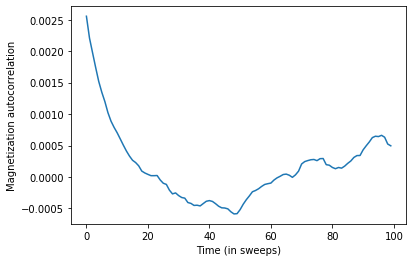

6.556853927672104


In [26]:
b0 = 1/2
I = np.ones(1000)

E_array = simulation(I, b0)[0]
m_array = simulation(I, b0)[1]

chi_array = []

for i in range(100): #get chi(0) to chi(300)
    chi_array.append(auto_correlation(m_array, 400, i))
    
t_array = np.arange(100)

plt.plot(t_array, chi_array)
plt.xlabel("Time (in sweeps)")
plt.ylabel("Magnetization autocorrelation")
plt.show()

print(corr_time(chi_array))

In [ ]:
print(simple_error(E_array))
I
print(np.average(E_array))

Comparing analytic to computationally determined energies at a variety of temperatures:

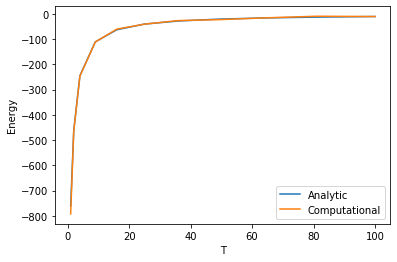

In [27]:
T_array = np.asarray([1, 2, 4, 9, 16, 25, 36, 49, 64, 81, 100])
beta_array = 1/T_array #k = 1
E_analytic = -N*np.tanh(1/T_array)

E_comp = []

for i in range(len(T_array)):
    I = np.ones(N)
    E_comp.append(np.average(simulation(I, 1/T_array[i])[0]))
    
plt.plot(T_array, E_analytic, label="Analytic")
plt.plot(T_array, E_comp, label="Computational")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()


Now comparing computational results to analytic at low temperature:

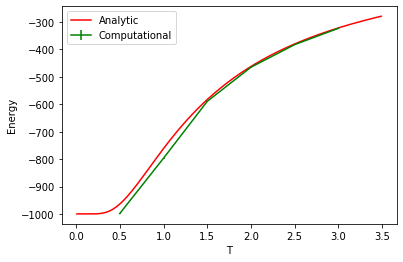

In [28]:
N = 1000
T_array1 = np.arange(0.01, 3.5, 0.02)
T_array2 = np.asarray([0.5, 1, 1.5, 2, 2.5, 3])
E_analytic = -N*np.tanh(1/T_array1)
E_comp = []
E_error = []

for i in range(len(T_array2)):
    I = np.ones(N)
    energy_list = simulation(I, 1/T_array2[i])[0]
    E_comp.append(np.average(energy_list))
    E_error.append(simple_error(energy_list))
    
    

plt.plot(T_array1, E_analytic, label="Analytic", color="red")
plt.errorbar(T_array2, E_comp, yerr = E_error, label="Computational", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()

In [29]:
print(E_comp)
print(E_error)

[-998.5731462925852, -796.8416833667335, -589.4108216432866, -464.80160320641284, -382.3887775551102, -322.82965931863725]
[0.10829211634363095, 1.7823536131800568, 1.552793014594248, 1.4204888305744534, 1.320774436185807, 1.4631681258771476]


Calculating magnetization:

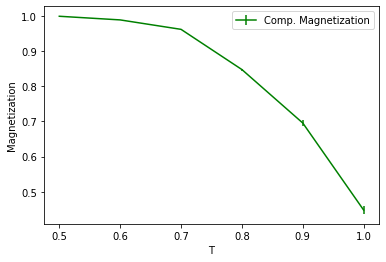

In [30]:
N = 1000
T_array2 = np.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 1])
m_comp = []
m_error = []

for i in range(len(T_array2)):
    I = np.ones(N)
    m_list = simulation(I, 1/T_array2[i])[1]
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list))

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Comp. Magnetization", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.show()


In [31]:
print(m_comp)
print(m_error)

[0.9993226452905811, 0.988937875751503, 0.9620841683366734, 0.8475951903807615, 0.6954228456913827, 0.4476072144288577]
[5.313660824190182e-05, 0.0002939345865447253, 0.0007516939368136955, 0.0027616788165700846, 0.007235409755566244, 0.01089517123601716]


Calculating specific heat:

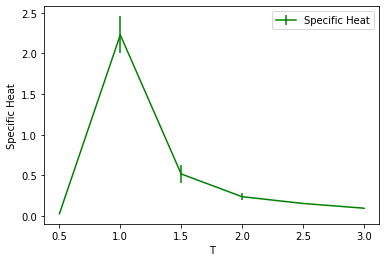

In [86]:
N = 1000
T_array2 = np.asarray([0.5, 1, 1.5, 2, 2.5, 3])
beta_array = 1/T_array2
c_comp = []
c_error = []

for i in range(len(T_array2)):
    I = np.ones(N)
    energy_list = simulation(I, 1/T_array2[i])[0]
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I)))
    
    
plt.errorbar(T_array2, c_comp, yerr = c_error, label="Specific Heat", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.show()

In [85]:
len(energy_list)
specific_heat(energy_list, beta_array[5], 1000)
c_bootstrap(energy_list, beta_array[5], 1000)

0.010406101248324504

In [72]:
a = randint(0, len(energy_list))
energy_list[a]
len(energy_list)

499